In [1]:
import pandas as pd
import numpy as np
import os

import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.callbacks import EarlyStopping, ModelCheckpoint

import keras
from keras.utils import np_utils
from keras.applications import mobilenet_v2
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model, load_model
from keras.layers import Flatten, Dense, Dropout, Conv2D, GlobalAveragePooling2D, MaxPooling2D, InputLayer, experimental
from keras.layers.experimental import preprocessing
from sklearn.metrics import confusion_matrix


import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive

In [4]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
path = "/content/drive/MyDrive/image_classification"

In [6]:
#Directory of training, test and validation folders
train_dir = os.path.join(path, "data", "train")
test_dir = os.path.join(path, "data", "test")    
val_dir = os.path.join(path, "data", "val")   

In [7]:
#Directories of data
train_cardboard = os.path.join(train_dir, "cardboard")
train_glass = os.path.join(train_dir, "glass")
train_metal = os.path.join(train_dir, "metal")
train_paper = os.path.join(train_dir, "paper")
train_plastic = os.path.join(train_dir, "plastic")
train_trash = os.path.join(train_dir, "trash")

test_cardboard = os.path.join(test_dir, "cardboard")
test_glass = os.path.join(test_dir, "glass")
test_metal = os.path.join(test_dir, "metal")
test_paper = os.path.join(test_dir, "paper")
test_plastic = os.path.join(test_dir, "plastic")
test_trash = os.path.join(test_dir, "trash")

val_cardboard = os.path.join(val_dir, "cardboard")
val_glass = os.path.join(val_dir, "glass")
val_metal = os.path.join(val_dir, "metal")
val_paper = os.path.join(val_dir, "paper")
val_plastic = os.path.join(val_dir, "plastic")
val_trash = os.path.join(val_dir, "trash")

In [8]:
#Covert images into tf datasets

directory = path + '/data/train'

dt_train = tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="categorical",
    class_names = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'],
    image_size=(224, 224),
    seed = 123,
    batch_size=30,
    shuffle=False
)

Found 1415 files belonging to 6 classes.


In [9]:
directory = path + '/data/test'

dt_test = tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="categorical",
    class_names = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'],
    image_size=(224, 224),
    seed = 123,
    batch_size=30,
    shuffle = False
)

Found 609 files belonging to 6 classes.


In [10]:
directory = path + '/data/val'

dt_val = tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="categorical",
    class_names = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'],
    image_size=(224, 224),
    seed = 123,
    batch_size=30,
    shuffle = False

)

Found 503 files belonging to 6 classes.


In [11]:
#Train a model from scrach as base model
num_class = 6

NN_scratch = Sequential(
                  [experimental.preprocessing.Rescaling(1./255, input_shape=(224, 224,3)),
                    Conv2D(filters=16, kernel_size=3, activation='relu', padding='same'),
                    MaxPooling2D(),
                    Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'),
                    MaxPooling2D(),
                    Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
                    MaxPooling2D(),
                    Flatten(),
                   
                    Dense(100, activation='relu'),
                    Dense(num_class, activation='softmax')
    
                   ])

NN_scratch.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)

In [17]:
NN_scratch.fit(dt_train, validation_data=dt_test, epochs=30)


Epoch 1/30
48/48 [==============================] - 690s 14s/step - loss: 8.7148 - accuracy: 0.6213 - val_loss: 2.1445 - val_accuracy: 0.1905
Epoch 2/30
48/48 [==============================] - 7s 145ms/step - loss: 2.0814 - accuracy: 0.0224 - val_loss: 1.7861 - val_accuracy: 0.2167
Epoch 3/30
48/48 [==============================] - 7s 144ms/step - loss: 1.8241 - accuracy: 0.3389 - val_loss: 1.8043 - val_accuracy: 0.1708
Epoch 4/30
48/48 [==============================] - 7s 142ms/step - loss: 1.9121 - accuracy: 0.4950 - val_loss: 1.7798 - val_accuracy: 0.2348
Epoch 5/30
48/48 [==============================] - 7s 140ms/step - loss: 1.7810 - accuracy: 0.2452 - val_loss: 1.7809 - val_accuracy: 0.2135
Epoch 6/30
48/48 [==============================] - 7s 139ms/step - loss: 1.8011 - accuracy: 0.0458 - val_loss: 1.7763 - val_accuracy: 0.2348
Epoch 7/30
48/48 [==============================] - 7s 140ms/step - loss: 1.7384 - accuracy: 0.1148 - val_loss: 1.7780 - val_accuracy: 0.2053
Epoch 

**Train a model from scratch is hard, I'll use transfer learning instead to create a base mode instead.**

In [39]:
#Base: MobileNet on non-scaled data

# note we exclude the final dense layers by setting include_top=False,
# and add new ones to train from scratch below
base_model = mobilenet_v2.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224,3)) 
 
# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False    

# Establish new fully connected block
x = base_model.output
x = Flatten()(x) # flatten from convolution tensor output 
predictions = Dense(6, activation='softmax')(x) # should match # of classes predicted

# define formal model object to train and compile it as usual
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [40]:
model.fit(dt_train, epochs=30, callbacks=[keras.callbacks.ModelCheckpoint('models/dt_train.{epoch:02d}-{val_loss:.2f}.hdf5',
               save_best_only=True)], validation_data=dt_test)

Epoch 1/30
48/48 [==============================] - 18s 197ms/step - loss: 56.6773 - accuracy: 0.4867 - val_loss: 150.2176 - val_accuracy: 0.1905


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/30
48/48 [==============================] - 6s 121ms/step - loss: 155.3859 - accuracy: 0.0762 - val_loss: 68.0749 - val_accuracy: 0.3629
Epoch 3/30
48/48 [==============================] - 6s 121ms/step - loss: 71.7639 - accuracy: 0.3146 - val_loss: 50.0631 - val_accuracy: 0.4154
Epoch 4/30
48/48 [==============================] - 6s 123ms/step - loss: 73.1808 - accuracy: 0.2463 - val_loss: 54.1769 - val_accuracy: 0.4598
Epoch 5/30
48/48 [==============================] - 6s 126ms/step - loss: 65.3617 - accuracy: 0.3343 - val_loss: 46.0531 - val_accuracy: 0.4795
Epoch 6/30
48/48 [==============================] - 6s 125ms/step - loss: 43.1100 - accuracy: 0.4775 - val_loss: 41.6081 - val_accuracy: 0.4614
Epoch 7/30
48/48 [==============================] - 6s 125ms/step - loss: 29.9760 - accuracy: 0.5515 - val_loss: 35.0669 - val_accuracy: 0.4680
Epoch 8/30
48/48 [==============================] - 6s 121ms/step - loss: 22.6653 - accuracy: 0.5982 - val_loss: 33.4802 - val_accuracy

The base model above has accuracy 0.70. But it's obvious overfitting.

In [42]:
#MobileNet Iteration 1: add one dense layers with 1000 neurons and dropout = 0.5; train on non_scaled data
base_model = mobilenet_v2.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3)) 
 
# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False    

# Establish new fully connected block
x = base_model.output
x = Flatten()(x) # flatten from convolution tensor output 
x = Dense(1000, activation='relu')(x) # number of layers and units are hyperparameters, as usual
x = Dropout(0.5)(x)
predictions = Dense(6, activation='softmax')(x) # should match # of classes predicted

# define formal model object to train and compile it as usual
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [43]:
#Add earlystop and checkpoint to save best weights only
filepath="models/dt_train.{epoch:02d}-{val_loss:.2f}.hdf5"

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint(filepath, monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [44]:
model.fit(dt_train, epochs=100, callbacks=[es,mc], validation_data=dt_test)  #increase epoch because we have early stop parameter applied

Epoch 1/100
48/48 [==============================] - 18s 199ms/step - loss: 310.6848 - accuracy: 0.4943 - val_loss: 136.7691 - val_accuracy: 0.1905
Epoch 2/100
48/48 [==============================] - 6s 130ms/step - loss: 147.8243 - accuracy: 0.0891 - val_loss: 16.4121 - val_accuracy: 0.2151
Epoch 3/100
48/48 [==============================] - 6s 129ms/step - loss: 13.9010 - accuracy: 0.1399 - val_loss: 1.7305 - val_accuracy: 0.2742
Epoch 4/100
48/48 [==============================] - 6s 125ms/step - loss: 1.7617 - accuracy: 0.1469 - val_loss: 1.6375 - val_accuracy: 0.2693
Epoch 5/100
48/48 [==============================] - 6s 132ms/step - loss: 1.7337 - accuracy: 0.1635 - val_loss: 1.6151 - val_accuracy: 0.3087
Epoch 6/100
48/48 [==============================] - 6s 130ms/step - loss: 1.6896 - accuracy: 0.0958 - val_loss: 1.5828 - val_accuracy: 0.3383
Epoch 7/100
48/48 [==============================] - 6s 130ms/step - loss: 1.6748 - accuracy: 0.0977 - val_loss: 1.5110 - val_accurac

The model still performs poorly. 
I'm going to try to rescale the pixel valus and run another iteration

In [11]:
#Rescale the pixel value to range[0,1]
pixel_scale = ImageDataGenerator(rescale = 1./255)

In [12]:
directory = path + '/data/train'

train_scaler = pixel_scale.flow_from_directory(
            directory,
            target_size = (224,224),
            class_mode = 'categorical',
            classes = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'],
            seed = 123,
            batch_size=30,
            shuffle=False)


Found 1415 images belonging to 6 classes.


In [13]:
directory = path + '/data/test'

test_scaler = pixel_scale.flow_from_directory(
            directory,
            target_size = (224,224),
            class_mode = 'categorical',
            classes = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'],
            seed = 123,
            batch_size=30,
            shuffle=False)


Found 609 images belonging to 6 classes.


In [14]:
directory = path + '/data/val'

val_scaler = pixel_scale.flow_from_directory(
            directory,
            target_size = (224,224),
            class_mode = 'categorical',
            classes = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'],
            seed = 123,
            batch_size=30,
            shuffle=False)

Found 503 images belonging to 6 classes.


In [49]:
#MobileNet Iteration 2: add one dense layers with 1000 neurons and dropout = 0.5; train on scaled pixel data
base_model = mobilenet_v2.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3)) 
 
# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False    

# Establish new fully connected block
x = base_model.output
x = Flatten()(x) # flatten from convolution tensor output 
x = Dense(1000, activation='relu')(x) # number of layers and units are hyperparameters, as usual
x = Dropout(0.5)(x)
predictions = Dense(6, activation='softmax')(x) # should match # of classes predicted

# define formal model object to train and compile it as usual
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [50]:
#Add earlystop and checkpoint to save best weights only
filepath="models/train_scaler.{epoch:02d}-{val_loss:.2f}.hdf5"

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint(filepath, monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [51]:
model.fit(train_scaler, epochs=30, callbacks=[es,mc], validation_data=test_scaler)

Epoch 1/30
48/48 [==============================] - 21s 281ms/step - loss: 77.7441 - accuracy: 0.2107 - val_loss: 1.1598 - val_accuracy: 0.4548
Epoch 2/30
48/48 [==============================] - 10s 209ms/step - loss: 1.2786 - accuracy: 0.4138 - val_loss: 1.0003 - val_accuracy: 0.6371
Epoch 3/30
48/48 [==============================] - 10s 206ms/step - loss: 1.0096 - accuracy: 0.6082 - val_loss: 0.8601 - val_accuracy: 0.6732
Epoch 4/30
48/48 [==============================] - 10s 209ms/step - loss: 0.8994 - accuracy: 0.6371 - val_loss: 0.8156 - val_accuracy: 0.7422
Epoch 5/30
48/48 [==============================] - 10s 210ms/step - loss: 0.7317 - accuracy: 0.7073 - val_loss: 0.7790 - val_accuracy: 0.7077
Epoch 6/30
48/48 [==============================] - 10s 208ms/step - loss: 0.6763 - accuracy: 0.7178 - val_loss: 0.6810 - val_accuracy: 0.7652
Epoch 7/30
48/48 [==============================] - 10s 204ms/step - loss: 0.6220 - accuracy: 0.7612 - val_loss: 0.7403 - val_accuracy: 0.775

Train the model on scaled data generate better performance. But still a little bit overfitting

In [54]:
Y_pred = model.predict(test_scaler)

y_pred = np.argmax(Y_pred, axis=1)

In [55]:
y_pred = np.argmax(Y_pred, axis=1)

In [56]:
cm = confusion_matrix(test_scaler.classes, y_pred)

In [57]:
waste_types = ['cardboard','glass','metal','paper','plastic','trash']

df_cm = pd.DataFrame(cm,waste_types,waste_types)

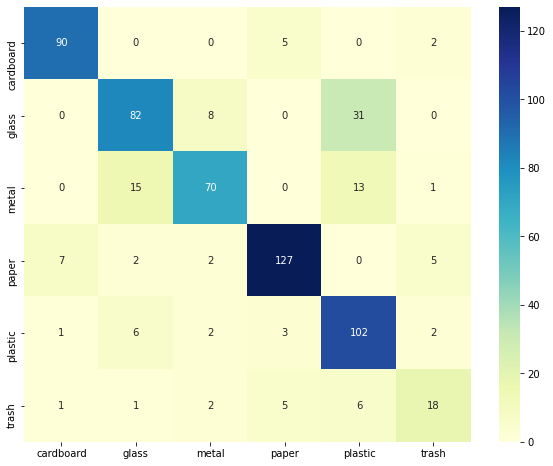

In [58]:
plt.figure(figsize=(10,8))
sns.heatmap(df_cm,annot=True,fmt="d",cmap="YlGnBu")

In [59]:
correct = 0

for r in range(len(cm)):
    for c in range(len(cm)):
        if(r==c):
            correct += cm[r,c]

In [60]:
correct/sum(sum(cm))

0.8029556650246306

In [15]:
#Apply photo augment to expand training data
train_datagen = ImageDataGenerator(
        rescale = 1./255,
        rotation_range = 20,
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        horizontal_flip = True,
        vertical_flip = True,
        brightness_range=(0.1, 0.9),
        fill_mode='nearest')

validation_datagen = ImageDataGenerator(
        rescale = 1./255)


test_datagen = ImageDataGenerator(
        rescale = 1./255)


In [16]:
directory = path + '/data/train'

train_generator = train_datagen.flow_from_directory(
            directory,
            target_size = (224,224),
            class_mode = 'categorical',
            classes = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'],
            seed = 123,
            batch_size=30,
            shuffle=False)


Found 1415 images belonging to 6 classes.


In [17]:
directory = path + '/data/test'

test_generator = validation_datagen.flow_from_directory(
            directory,
            target_size = (224,224),
            batch_size = 30,
            class_mode = 'categorical',
            classes = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'],
            seed = 123,
            shuffle=False)

Found 609 images belonging to 6 classes.


In [18]:
directory = path + '/data/val'

validation_generator = validation_datagen.flow_from_directory(
            directory,
            target_size = (224,224),
            batch_size = 30,
            class_mode = 'categorical',
            classes = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'],
            seed = 123,
            shuffle=False)

Found 503 images belonging to 6 classes.


In [71]:
#MobileNet Iteration 3: add more dense layers; train on data after augment; change learning ratio
base_model = mobilenet_v2.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3)) 
 
# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False    

# Establish new fully connected block
x = base_model.output
x = Flatten()(x) # flatten from convolution tensor output 
x = Dense(1100, activation='relu')(x) # number of layers and units are hyperparameters, as usual
x = Dropout(0.2)(x)
x = Dense(400, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(6, activation='softmax')(x) # should match # of classes predicted

# define formal model object to train and compile it as usual
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Nadam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy']) #lower learning ratio

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [75]:
filepath="models/train_generator.{epoch:02d}-{val_loss:.2f}.hdf5"

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint(filepath, monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [76]:
model.fit(train_generator, epochs=100, callbacks=[es,mc], validation_data=test_generator)

Epoch 1/100
48/48 [==============================] - 28s 576ms/step - loss: 0.5938 - accuracy: 0.7640 - val_loss: 0.5614 - val_accuracy: 0.8177
Epoch 2/100
48/48 [==============================] - 27s 561ms/step - loss: 0.5481 - accuracy: 0.7979 - val_loss: 0.4777 - val_accuracy: 0.8555
Epoch 3/100
48/48 [==============================] - 28s 586ms/step - loss: 0.5266 - accuracy: 0.8141 - val_loss: 0.6104 - val_accuracy: 0.7668
Epoch 4/100
48/48 [==============================] - 28s 586ms/step - loss: 0.5321 - accuracy: 0.7958 - val_loss: 0.5293 - val_accuracy: 0.8259
Epoch 5/100
48/48 [==============================] - 27s 562ms/step - loss: 0.4911 - accuracy: 0.8163 - val_loss: 0.5836 - val_accuracy: 0.8210
Epoch 6/100
48/48 [==============================] - 27s 567ms/step - loss: 0.4976 - accuracy: 0.8170 - val_loss: 0.5357 - val_accuracy: 0.8243
Epoch 7/100
48/48 [==============================] - 27s 572ms/step - loss: 0.4941 - accuracy: 0.8134 - val_loss: 0.6259 - val_accuracy:

In [93]:
Y_pred = model.predict(test_generator)

y_pred = np.argmax(Y_pred, axis=1)

In [95]:
y_pred = np.argmax(Y_pred, axis=1)

In [99]:
cm = confusion_matrix(test_generator.classes, y_pred)

In [100]:
waste_types = ['cardboard','glass','metal','paper','plastic','trash']

df_cm = pd.DataFrame(cm,waste_types,waste_types)

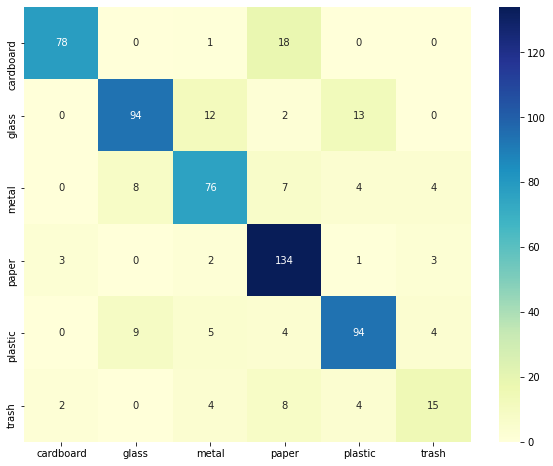

In [101]:
plt.figure(figsize=(10,8))
sns.heatmap(df_cm,annot=True,fmt="d",cmap="YlGnBu")

In [102]:
correct = 0

for r in range(len(cm)):
    for c in range(len(cm)):
        if(r==c):
            correct += cm[r,c]

In [103]:
correct/sum(sum(cm))

0.80623973727422

In [104]:
#Save the model
model.save('/content/drive/MyDrive/Colab Notebooks/image_classification/models/JULY7_mobilenet_final')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/image_classification/models/JULY7_mobilenet_final/assets


**VGG16**

In [106]:
#vgg16 Iteration 1: apply same parameters from MobileNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3)) 
 
# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False    

# Establish new fully connected block
x = base_model.output
x = Flatten()(x) # flatten from convolution tensor output 
x = Dense(1100, activation='relu')(x) # number of layers and units are hyperparameters, as usual
x = Dropout(0.2)(x)
x = Dense(400, activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(6, activation='softmax')(x) # should match # of classes predicted

# define formal model object to train and compile it as usual
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Nadam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy']) #lower learning ratio

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [108]:
filepath="models/train_generator.{epoch:02d}-{val_loss:.2f}.hdf5"

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint(filepath, monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [109]:
model.fit(train_generator, epochs=100, callbacks=[es,mc], validation_data=test_generator)

Epoch 1/30
48/48 [==============================] - 34s 623ms/step - loss: 2.4427 - accuracy: 0.1562 - val_loss: 1.8409 - val_accuracy: 0.2348
Epoch 2/30
48/48 [==============================] - 28s 583ms/step - loss: 1.8466 - accuracy: 0.2728 - val_loss: 1.5702 - val_accuracy: 0.3218
Epoch 3/30
48/48 [==============================] - 28s 590ms/step - loss: 1.7681 - accuracy: 0.2416 - val_loss: 1.6429 - val_accuracy: 0.3251
Epoch 4/30
48/48 [==============================] - 28s 590ms/step - loss: 1.4837 - accuracy: 0.4312 - val_loss: 1.3483 - val_accuracy: 0.4220
Epoch 5/30
48/48 [==============================] - 28s 578ms/step - loss: 1.6228 - accuracy: 0.2784 - val_loss: 1.5586 - val_accuracy: 0.3990
Epoch 6/30
48/48 [==============================] - 28s 603ms/step - loss: 1.6307 - accuracy: 0.3012 - val_loss: 1.2749 - val_accuracy: 0.4778
Epoch 7/30
48/48 [==============================] - 27s 571ms/step - loss: 1.4948 - accuracy: 0.3757 - val_loss: 1.2742 - val_accuracy: 0.4877

In [19]:
from tensorflow.keras.layers import BatchNormalization

In [20]:

train_datagen_VGG = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
        shear_range=0.2,
        zoom_range=0.2,
        width_shift_range=0.2,
        height_shift_range=0.2)

validation_datagen_VGG = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)


test_datagen_VGG = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)

In [21]:
directory = path + '/data/train'

train_generator_VGG = train_datagen_VGG.flow_from_directory(
            directory,
            target_size = (224,224),
            class_mode = 'categorical',
            classes = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'],
            seed = 123,
            batch_size=30,
            shuffle=False)

Found 1415 images belonging to 6 classes.


In [22]:
directory = path + '/data/test'

test_generator_VGG = test_datagen_VGG.flow_from_directory(
            directory,
            target_size = (224,224),
            class_mode = 'categorical',
            classes = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'],
            seed = 123,
            batch_size=30,
            shuffle=False)

Found 609 images belonging to 6 classes.


In [23]:
directory = path + '/data/val'

validation_generator_VGG = validation_datagen_VGG.flow_from_directory(
            directory,
            target_size = (224,224),
            batch_size = 30,
            class_mode = 'categorical',
            classes = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'],
            seed = 123,
            shuffle=False)

Found 503 images belonging to 6 classes.


In [160]:
#vgg16 Iteration 2: increase model complexity
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3)) 
 
# Unfreeze last 3 layers because of overfitting
for layer in base_model.layers:
    layer.trainable = False    

# Establish new fully connected block
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(300, activation='relu')(x) # number of layers and units are hyperparameters, as usual
x = BatchNormalization()(x) #Normalize layer outputs (mean=0, std=1)
x = Dropout(0.3)(x)
x = Dense(50, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

predictions = Dense(6, activation='softmax')(x) # should match # of classes predicted

# define formal model object to train and compile it as usual
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Nadam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy']) #lower learning ratio

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [34]:
filepath="models/train_generator_VGG.{epoch:02d}-{val_loss:.2f}.hdf5"
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint(filepath, monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [162]:
model.fit(train_generator_VGG, epochs=100, callbacks=[es,mc], validation_data=test_generator_VGG)

Epoch 1/100
48/48 [==============================] - 26s 508ms/step - loss: 4.4543 - accuracy: 0.1561 - val_loss: 1.9542 - val_accuracy: 0.3350
Epoch 2/100
48/48 [==============================] - 24s 491ms/step - loss: 2.6819 - accuracy: 0.2425 - val_loss: 1.5091 - val_accuracy: 0.4433
Epoch 3/100
48/48 [==============================] - 24s 511ms/step - loss: 2.2220 - accuracy: 0.3003 - val_loss: 1.2971 - val_accuracy: 0.5337
Epoch 4/100
48/48 [==============================] - 24s 495ms/step - loss: 1.7141 - accuracy: 0.3978 - val_loss: 1.1328 - val_accuracy: 0.5780
Epoch 5/100
48/48 [==============================] - 24s 494ms/step - loss: 1.6375 - accuracy: 0.4150 - val_loss: 1.0593 - val_accuracy: 0.6108
Epoch 6/100
48/48 [==============================] - 24s 501ms/step - loss: 1.4319 - accuracy: 0.4731 - val_loss: 0.9995 - val_accuracy: 0.6453
Epoch 7/100
48/48 [==============================] - 24s 494ms/step - loss: 1.3583 - accuracy: 0.4945 - val_loss: 0.9524 - val_accuracy:

In [173]:
Y_pred = model.predict(test_generator_VGG)

y_pred = np.argmax(Y_pred, axis=1)

In [175]:
y_pred = np.argmax(Y_pred, axis=1)

In [176]:
cm = confusion_matrix(test_generator.classes, y_pred)

In [177]:
waste_types = ['cardboard','glass','metal','paper','plastic','trash']

df_cm = pd.DataFrame(cm,waste_types,waste_types)

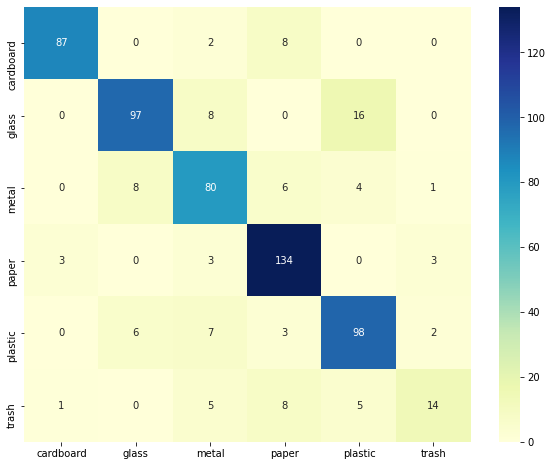

In [178]:
plt.figure(figsize=(10,8))
sns.heatmap(df_cm,annot=True,fmt="d",cmap="YlGnBu")

In [179]:
correct = 0

for r in range(len(cm)):
    for c in range(len(cm)):
        if(r==c):
            correct += cm[r,c]

In [180]:
correct/sum(sum(cm))

0.8374384236453202

In [163]:
#Save the model
model.save('/content/drive/MyDrive/Colab Notebooks/image_classification/models/JULY7_VGG16_V1')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/image_classification/models/JULY7_VGG16_V1/assets


In [182]:
#vgg16 Iteration 2: increase model complexity
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3)) 
 
# Unfreeze last 3 layers because of overfitting
for layer in base_model.layers:
    layer.trainable = False    

# Establish new fully connected block
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(200, activation='relu')(x) # number of layers and units are hyperparameters, as usual
x = BatchNormalization()(x) #Normalize layer outputs (mean=0, std=1)
x = Dropout(0.3)(x)
x = Dense(50, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

predictions = Dense(6, activation='softmax')(x) # should match # of classes predicted

# define formal model object to train and compile it as usual
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Nadam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy']) #lower learning ratio

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [183]:
model.fit(train_generator_VGG, epochs=100, callbacks=[es,mc], validation_data=test_generator_VGG)

Epoch 1/100
48/48 [==============================] - 26s 496ms/step - loss: 3.6020 - accuracy: 0.1621 - val_loss: 2.1499 - val_accuracy: 0.2693
Epoch 2/100
48/48 [==============================] - 23s 487ms/step - loss: 2.4534 - accuracy: 0.2570 - val_loss: 1.6994 - val_accuracy: 0.3612
Epoch 3/100
48/48 [==============================] - 22s 465ms/step - loss: 2.2300 - accuracy: 0.3030 - val_loss: 1.4714 - val_accuracy: 0.4483
Epoch 4/100
48/48 [==============================] - 23s 479ms/step - loss: 1.6961 - accuracy: 0.4007 - val_loss: 1.3277 - val_accuracy: 0.4992
Epoch 5/100
48/48 [==============================] - 23s 480ms/step - loss: 1.6949 - accuracy: 0.3862 - val_loss: 1.2397 - val_accuracy: 0.5616
Epoch 6/100
48/48 [==============================] - 22s 469ms/step - loss: 1.4796 - accuracy: 0.4529 - val_loss: 1.1648 - val_accuracy: 0.5846
Epoch 7/100
48/48 [==============================] - 23s 483ms/step - loss: 1.4069 - accuracy: 0.4852 - val_loss: 1.1011 - val_accuracy:

In [185]:
Y_pred = model.predict(test_generator_VGG)

y_pred = np.argmax(Y_pred, axis=1)

In [186]:
y_pred = np.argmax(Y_pred, axis=1)

In [197]:
cm = confusion_matrix(test_generator_VGG.classes, y_pred)

In [198]:
waste_types = ['cardboard','glass','metal','paper','plastic','trash']

df_cm = pd.DataFrame(cm,waste_types,waste_types)

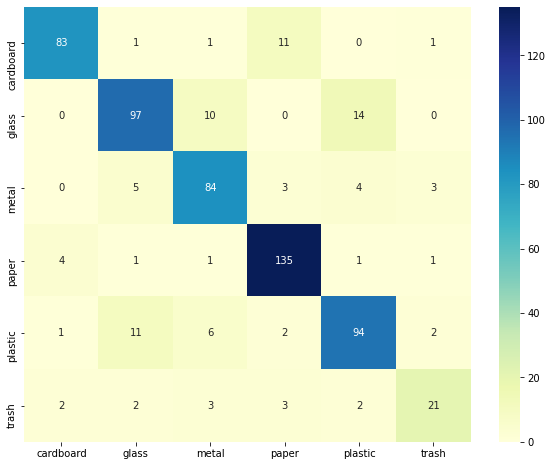

In [199]:
plt.figure(figsize=(10,8))
sns.heatmap(df_cm,annot=True,fmt="d",cmap="YlGnBu")

In [200]:
correct = 0

for r in range(len(cm)):
    for c in range(len(cm)):
        if(r==c):
            correct += cm[r,c]

In [201]:
correct/sum(sum(cm))

0.8440065681444991

In [184]:
#Save the model
model.save('/content/drive/MyDrive/Colab Notebooks/image_classification/models/JULY7_VGG16_V2')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/image_classification/models/JULY7_VGG16_V2/assets


**InceptionV3**

In [211]:
from keras.applications.inception_v3 import InceptionV3

In [25]:
#Apply photo augment to expand training data
train_datagen_INC = ImageDataGenerator(
        rescale = 1./255,
        rotation_range = 30,
        width_shift_range = 0.1,
        height_shift_range = 0.1,
        horizontal_flip = True,
        vertical_flip = True,
        shear_range=0.1,
        zoom_range=0.1,
        )

validation_datagen_INC = ImageDataGenerator(rescale = 1./255)


test_datagen_INC = ImageDataGenerator(rescale = 1./255)


In [26]:
directory = path + '/data/train'

train_generator_INC = train_datagen_INC.flow_from_directory(
            directory,
            target_size = (300,300),
            class_mode = 'categorical',
            classes = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'],
            seed = 123,
            batch_size=30,
            shuffle=False)

Found 1415 images belonging to 6 classes.


In [27]:
directory = path + '/data/test'

test_generator_INC = test_datagen_INC.flow_from_directory(
            directory,
            target_size = (300,300),
            class_mode = 'categorical',
            classes = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'],
            seed = 123,
            batch_size=30,
            shuffle=False)

Found 609 images belonging to 6 classes.


In [28]:
directory = path + '/data/val'

val_generator_INC = validation_datagen_INC.flow_from_directory(
            directory,
            target_size = (300,300),
            class_mode = 'categorical',
            classes = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'],
            seed = 123,
            batch_size=30,
            shuffle=False)

Found 503 images belonging to 6 classes.


In [224]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(300,300,3)) 
 
# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False    

# Establish new fully connected block
x = base_model.output
x = GlobalAveragePooling2D()(x) 
x = Flatten()(x) 
x = Dense(1500, activation='relu')(x) # number of layers and units are hyperparameters, as usual
x = Dropout(0.15)(x)
x = Dense(500, activation='relu')(x)
x = Dropout(0.15)(x)

predictions = Dense(6, activation='softmax')(x) # should match # of classes predicted

# define formal model object to train and compile it as usual
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Nadam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy']) #lower learning ratio

In [225]:
batch_size = 200
epochs = 3000

steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

In [226]:
filepath="models/train_generator_INC.{epoch:02d}-{val_loss:.2f}.hdf5"

mc = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10) #try 10

In [227]:
model.fit(train_generator_INC, 
          epochs=epochs, 
          steps_per_epoch=steps_per_epoch,  
          validation_data=test_generator_INC, 
          validation_steps=validation_steps, 
          callbacks=[mc, es])

Epoch 1/3000
7/7 [==============================] - 26s 2s/step - loss: 2.0128 - accuracy: 0.1208 - val_loss: 1.3766 - val_accuracy: 0.2333
Epoch 2/3000
7/7 [==============================] - 6s 812ms/step - loss: 1.6729 - accuracy: 0.2903 - val_loss: 1.2009 - val_accuracy: 0.7500
Epoch 3/3000
7/7 [==============================] - 6s 806ms/step - loss: 1.6978 - accuracy: 0.3224 - val_loss: 0.6541 - val_accuracy: 1.0000
Epoch 4/3000
7/7 [==============================] - 6s 811ms/step - loss: 1.2874 - accuracy: 0.5675 - val_loss: 0.9703 - val_accuracy: 0.6500
Epoch 5/3000
7/7 [==============================] - 6s 823ms/step - loss: 1.6242 - accuracy: 0.3052 - val_loss: 0.5992 - val_accuracy: 0.9833
Epoch 6/3000
7/7 [==============================] - 6s 809ms/step - loss: 1.3693 - accuracy: 0.4101 - val_loss: 0.7761 - val_accuracy: 0.8833
Epoch 7/3000
7/7 [==============================] - 5s 762ms/step - loss: 0.7480 - accuracy: 0.8313 - val_loss: 0.5816 - val_accuracy: 0.7167
Epoch 8/

**Final Model: VGG16**

In [24]:
#Load the best performed MobileNet model
vgg_source = '/content/drive/MyDrive/Colab Notebooks/image_classification/models/JULY7_VGG16_V2'

In [25]:
vgg_final = load_model(vgg_source)

In [35]:
history = vgg_final.fit(train_generator_VGG, epochs=50, callbacks=[es,mc], validation_data=validation_generator_VGG)

Epoch 1/50
48/48 [==============================] - 366s 7s/step - loss: 0.3685 - accuracy: 0.8608 - val_loss: 0.5258 - val_accuracy: 0.8529
Epoch 2/50
48/48 [==============================] - 20s 408ms/step - loss: 0.3328 - accuracy: 0.8841 - val_loss: 0.5323 - val_accuracy: 0.8469
Epoch 3/50
48/48 [==============================] - 19s 405ms/step - loss: 0.3436 - accuracy: 0.8834 - val_loss: 0.5366 - val_accuracy: 0.8370
Epoch 4/50
48/48 [==============================] - 20s 407ms/step - loss: 0.2986 - accuracy: 0.8912 - val_loss: 0.5409 - val_accuracy: 0.8429
Epoch 5/50
48/48 [==============================] - 19s 403ms/step - loss: 0.3115 - accuracy: 0.8905 - val_loss: 0.5383 - val_accuracy: 0.8489
Epoch 6/50
48/48 [==============================] - 19s 403ms/step - loss: 0.3334 - accuracy: 0.8848 - val_loss: 0.5508 - val_accuracy: 0.8410
Epoch 00006: early stopping


In [36]:
Y_pred = vgg_final.predict(validation_generator_VGG)

y_pred = np.argmax(Y_pred, axis=1)

In [37]:
cm = confusion_matrix(validation_generator_VGG.classes, y_pred)

In [38]:
waste_types = ['cardboard','glass','metal','paper','plastic','trash']

df_cm = pd.DataFrame(cm,waste_types,waste_types)

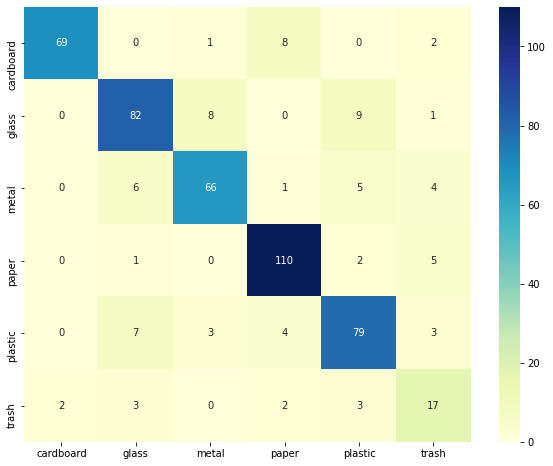

In [39]:
plt.figure(figsize=(10,8))
sns.heatmap(df_cm,annot=True,fmt="d",cmap="YlGnBu")

In [40]:
correct = 0

for r in range(len(cm)):
    for c in range(len(cm)):
        if(r==c):
            correct += cm[r,c]

In [41]:
correct/sum(sum(cm))

0.8409542743538767

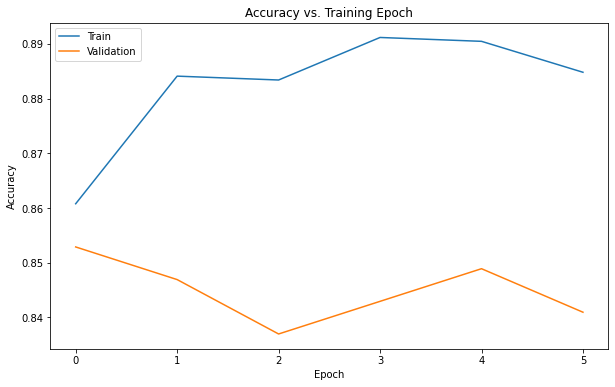

In [42]:
plt.figure(figsize= (10,6))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Accuracy vs. Training Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Validation'])

In [43]:
pre_outputs = pd.DataFrame(zip(y_pred, validation_generator_VGG.labels), columns = {'pred_label', 'actual_label'})

In [44]:
pre_outputs

,actual_label,pred_label
0,0,0
1,0,0
2,0,0
3,0,0
4,2,0
...,...,...
498,1,5
499,5,5
500,0,5
501,5,5


In [45]:
pre_outputs[pre_outputs['pred_label'] != pre_outputs['actual_label']]

,actual_label,pred_label
4,2,0
7,5,0
12,3,0
18,3,0
22,3,0
...,...,...
494,0,5
495,3,5
498,1,5
500,0,5


In [50]:
pre_outputs.to_csv(r'/content/drive/MyDrive/Colab Notebooks/image_classification/pre_outputs.csv', index = False)

In [60]:
top1 = 0.0
top3 = 0.0    

class_probs = vgg_final.predict(validation_generator_VGG)
for i, l in enumerate(validation_generator_VGG.labels):
    class_prob = class_probs[i]
    top_values = (-class_prob).argsort()[:3]
    if top_values[0] == l:
        top1 += 1.0
    if np.isin(np.array([l]), top_values):
        top3 += 1.0

print("top1 acc", top1/len(validation_generator_VGG.labels))
print("top3 acc", top3/len(validation_generator_VGG.labels))

top1 acc 0.8409542743538767
top3 acc 0.9801192842942346
